In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Polygon
import matplotlib.pyplot as plt

C:\Users\aance\AppData\Local\Temp\ipykernel_47532\307296089.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load in data
blocks = gpd.read_file('./data/blocksWMinWalkDrivDistances_fromJerry3.geojson')
stations = gpd.read_file('./data/Fire_Stations.geojson')
cityBounds = gpd.read_file('./data/Boundaries - City.geojson') # city boundary. Just used to filter the fire stations to Chicago

In [3]:
# Make sure all data sets use same coordinate system
blocks = blocks.to_crs('epsg:26916')
stations = stations.to_crs('epsg:26916')
cityBounds = cityBounds.to_crs('epsg:26916')
assert blocks.crs.equals(stations.crs) and stations.crs.equals(cityBounds.crs)

In [4]:
# set the index of the city blocks. Not used later, but is good practice
assert not blocks['GEOID'].duplicated().any()
blocks.set_index('GEOID',inplace=True)

In [5]:
# filter stations for just those in Chicago
stations = stations.loc[stations.within(cityBounds.loc[0,'geometry'])]

C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


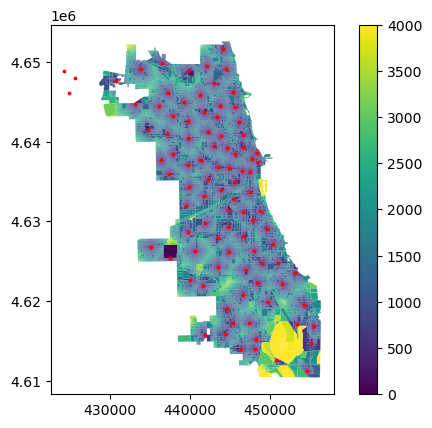

In [6]:
# plot the stations & blocks, colored by openstreetmaps distance to nearest station
# just as a sanity check to make sure everything looks good
ax = blocks.plot('distance_to_nearest_station',legend=True,vmax=4000)
stations.plot(color='red',markersize=3,ax=ax)
plt.savefig('distToNearestStation.pdf')

In [7]:
blocks.head()

,OBJECTID,AREALAND,AREAWATER,BASENAME,BLKGRP,BLOCK,oldCENTLAT,oldCENTLON,COUNTY,FUNCSTAT,...,inCity,onBound,centroidLat,centroidLon,closestStation,distToStation,stationLat,stationLon,distance_to_nearest_station,geometry
GEOID,,,,,,,,,,,,,,,,,,,,,
170312001003024,3401952,3762.0,0.0,3024,3,3024,+41.9325268,-087.7405959,031,S,...,True,False,41.932527,-87.740596,23902.0,1027.232615,41.938601,-87.749941,1506.282,"MULTIPOLYGON (((438589.681 4642651.141, 438598..."
170312001003016,3401953,3765.0,0.0,3016,3,3016,+41.9343498,-087.7406595,031,S,...,True,False,41.934350,-87.740660,23902.0,902.759599,41.938601,-87.749941,1195.485,"MULTIPOLYGON (((438586.041 4642853.593, 438595..."
170312001003017,3401954,3771.0,0.0,3017,3,3017,+41.9361742,-087.7407233,031,S,...,True,False,41.936174,-87.740723,23902.0,810.333646,41.938601,-87.749941,1093.874,"MULTIPOLYGON (((438582.485 4643056.155, 438591..."
170312001003002,3401955,3800.0,0.0,3002,3,3002,+41.9379988,-087.7407878,031,S,...,True,False,41.937999,-87.740788,23902.0,761.800650,41.938601,-87.749941,784.144,"MULTIPOLYGON (((438578.765 4643258.830, 438588..."
170310510001003,3401956,5134.0,0.0,1003,1,1003,+41.9428693,-087.6875213,031,S,...,True,False,41.942869,-87.687521,23418.0,631.493117,41.937897,-87.683822,804.367,"MULTIPOLYGON (((442957.911 4643687.458, 442978..."


428548.14418053237 4610444.670547147 456392.1387061812 4652555.8845747225


C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


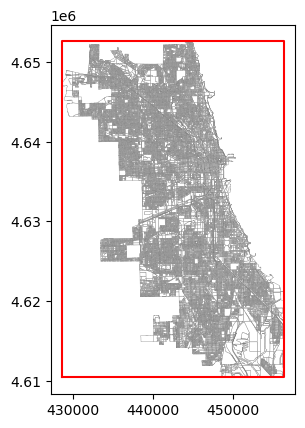

In [8]:
# find bounding box of the city
(minx,miny,maxx,maxy) = blocks.total_bounds # get bounds of city
print(minx,miny,maxx,maxy)
bbox = [(minx,miny),(maxx,miny),(maxx,maxy),(minx,maxy)]

# plot the bbox just to make sure it worked correctly
ax = blocks.plot(color='white',edgecolor='grey',linewidth=0.25)
ax.plot(*LineString(bbox+[bbox[0]]).xy,color='red')

In [9]:
buffer = 1000 # distance in meters around bounding box to include in the grid
NRectsSmallSide = 1000 # number of squares to put on the smaller side

sideLen = (maxx-minx)/NRectsSmallSide
gridLines_lon = np.arange(minx-buffer,maxx+buffer,sideLen)
gridLines_lat = np.arange(miny-buffer,maxy+buffer,sideLen) # NOTE: adjust since last square might not use full sideLen as jump

# helper function, outputs a square given the coords of lower left and upper right corners
def rectCoords(minx,miny,maxx,maxy):
    return Polygon([(minx,miny),(maxx,miny),(maxx,maxy),(minx,maxy)])

# Create dataframe containing all the grid squares
squares = []
for i in range(len(gridLines_lon)-1):
    if i % 100 == 0: print(i)
    for j in range(len(gridLines_lat)-1):
        coords = rectCoords(gridLines_lon[i],gridLines_lat[j],gridLines_lon[i+1],gridLines_lat[j+1])
        squares.append(coords)

grid = gpd.GeoDataFrame(geometry=squares)
grid['val'] = 0.0 # the value assigned to each grid square. Will be updated later

0
100
200
300
400
500
600
700
800
900
1000


C:\Users\aance\anaconda3\envs\geoEnv\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

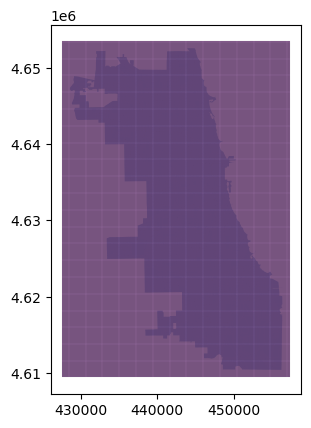

In [9]:
# sanity check: plot the grid over the city blocks
ax = blocks.plot(alpha=0.3)
grid.plot('val',ax=ax,edgecolor='black',linewidth=0.05,alpha=0.6)

In [ ]:
# assign to each grid square the average value of the census blocks it intersects, weighted by their areas
for i in range(len(grid)):
    blocksInt = blocks[grid.loc[i,'geometry'].intersects(blocks['geometry'])]
    if len(blocksInt) == 0:
        continue
    grid.at[i,'val'] = np.average(blocksInt['distance_to_nearest_station'],weights=blocksInt.intersection(grid.loc[i,'geometry']).area)

In [ ]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(10,15),sharex=True,sharey=True)
blocks.plot('distance_to_nearest_station',legend=True,vmax=4000,ax=axs[0])
stations.plot(color='red',markersize=3,ax=axs[0])

# blocks.plot(alpha=0.7,ax=axs[1])
grid.plot('val',ax=axs[1],edgecolor='black',linewidth=0.05)

In [ ]:
# save results
grid.to_file(f'./data/rectGrid_{NRectsSmallSide}RectsSmallSide.geojson',index=False,driver='GeoJSON') # index=False was required for some reason. Without it, geopandas threw: "AttributeError: module 'pandas' has no attribute 'Int64Index'" for some reason

In [17]:
grid.head()

,geometry,val
0,"POLYGON ((427548.144 4609444.671, 427687.364 4...",0.0
1,"POLYGON ((427548.144 4609583.891, 427687.364 4...",0.0
2,"POLYGON ((427548.144 4609723.110, 427687.364 4...",0.0
3,"POLYGON ((427548.144 4609862.330, 427687.364 4...",0.0
4,"POLYGON ((427548.144 4610001.550, 427687.364 4...",0.0
